In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random

In [ ]:
!git clone https://github.com/JoseMauricioBazagoitiaAyllon/Inteligencia-Artificial-II.git

Cloning into 'Inteligencia-Artificial-II'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 185 (delta 9), reused 7 (delta 7), pack-reused 174
Receiving objects: 100% (185/185), 59.69 MiB | 23.42 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [ ]:
cd /content/Inteligencia-Artificial-II/ExamenFinal/Pregunta1

/content/Inteligencia-Artificial-II/ExamenFinal/Pregunta1


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py ->

In [ ]:
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [ ]:
ROOT_DIR = '/content/Inteligencia-Artificial-II/ExamenFinal/Pregunta1'
# Directorio para guardar registros y modelo entrenado
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Ruta local al archivo de pesos pre-entrenados de coco
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Descargamos los pesos entrenados por COCO de las versiones anteriores si es necesario
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
class GallinaConfig(Config):
    # Damos a nuestra configuración el nombre del dataset en este caso paloma
    NAME = "gallina"

    # Entrene con 1 GPU y 1 imagen por GPU. El tamaño del lote es 1 (GPU * imágenes / GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Número de clases (incluidos los del background)en esta caso solo tenemos una clase 
    NUM_CLASSES = 1 + 1  # background + 1 (gallina)

    # Todas nuestras imágenes de entrenamiento seran de 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    STEPS_PER_EPOCH = 100


    VALIDATION_STEPS = 5
    
    #  Aqui usamos una resnet50
    BACKBONE = 'resnet50'

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 

config = GallinaConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
class GallinaDataset(utils.Dataset):

    def load_gallina(self, dataset_dir, subset):
        # Agregamos las clases. Solo tenemos una clase para agregar.
        self.add_class("gallina", 1, "gallina")

        # Aqui elegimos que tipo de dataset queremos train o val?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Cargamos nuestras anotaciones
      
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # La herramienta VIA guarda imágenes en JSON incluso si no tienen ninguna anotaciones.
        # Omitimos las imágenes sin anotar por obvias razones.
        annotations = [a for a in annotations if a['regions']]

        # Agregamos las imagenes
        for a in annotations:
            # Obtener las coordenadas x, y de los puntos de los polígonos que forman
            # el esquema de cada instancia de objeto. Estas son tiendas en el
            # shape_attributes (ver formato json arriba)
            # La condición if es necesaria para admitir las versiones 1.xy 2.x de VIA.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() necesita el tamaño de la imagen para convertir polígonos en máscaras.
            # Desafortunadamente, VIA no lo incluye en JSON, por lo que debemos leer
            # la imagen. Esto solo se puede administrar ya que el conjunto de datos es pequeño.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "gallina",
                image_id=a['filename'],  # use el filename como una identificación de imagen única
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Genera máscaras de instancia para una imagen.
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # Si no es una imagen de dataset de paloma, delegue a la clase principal.
        image_info = self.image_info[image_id]
        if image_info["source"] != "gallina":
            return super(self.__class__, self).load_mask(image_id)

        # Convertir polígonos en una máscara de forma de mapa de bits
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            # Obtenga índices de píxeles dentro del polígono y configúrelos en 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # retornamos la Máscara y matriz de ID de clase de cada instancia. Desde que tenemos
        # solo un ID de clase, devolvemos una matriz de 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Devuelve la ruta de la imagen."""
        info = self.image_info[image_id]
        if info["source"] == "paloma":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
# Dataset de Entrenamiento
dataset_train = GallinaDataset()
dataset_train.load_gallina("/content/Inteligencia-Artificial-II/ExamenFinal/Pregunta1/dataset/gallina", "train")
dataset_train.prepare()

# Dataset de Validacion
dataset_val = GallinaDataset()
dataset_val.load_gallina("/content/Inteligencia-Artificial-II/ExamenFinal/Pregunta1/dataset/gallina", "val")
dataset_val.prepare()

In [ ]:
#  Creamos modelo en modo de entrenamiento
model = modellib.MaskRCNN(mode="training" , config=config , model_dir=MODEL_DIR)

In [ ]:
init_with = "coco"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


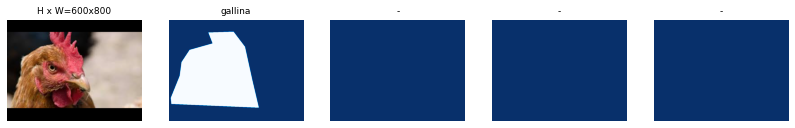

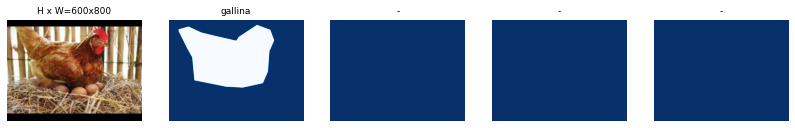

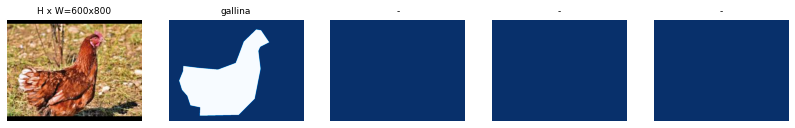

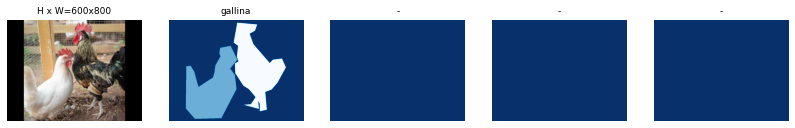

In [ ]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image_id  71 None
image                    shape: (600, 800, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (600, 800, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   88.00000  max:  750.00000  int32


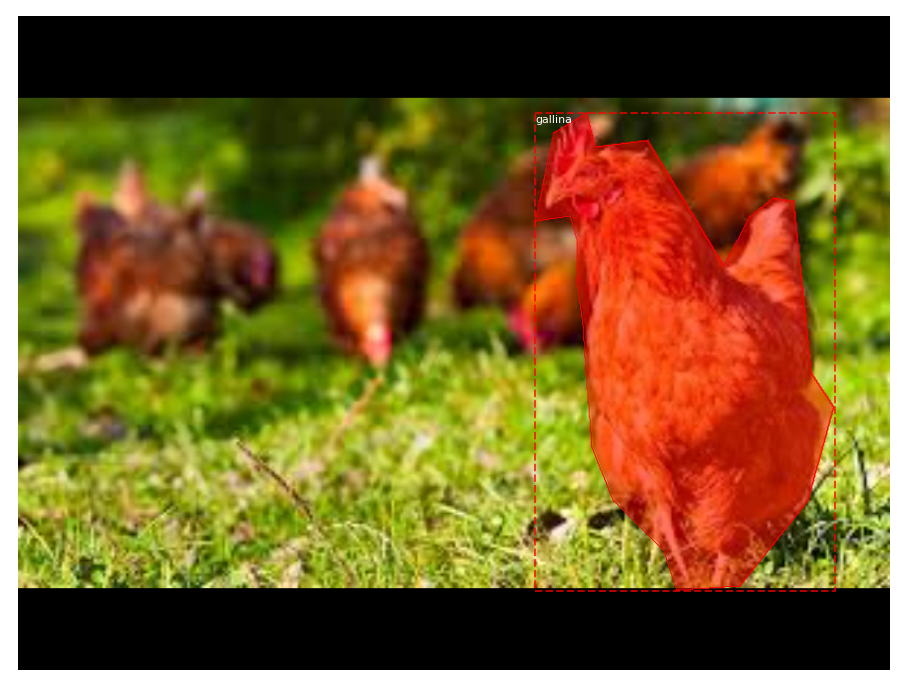

In [ ]:
from mrcnn.model import log
# Cargamos la imagen y la máscara aleatoriamente
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Calculamos el cuadro delimitador
bbox = utils.extract_bboxes(mask)

# Mostramos imagen y estadísticas adicionales
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Inteligencia-Artificial-II/ExamenFinal/Pregunta1/logs/gallina20220729T1612/mask_rcnn_gallina_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(imag

  1/100 [..............................] - ETA: 24:24 - batch: 0.0000e+00 - size: 1.0000 - loss: 13.3224 - rpn_class_loss: 11.0729 - rpn_bbox_loss: 1.6038 - mrcnn_class_loss: 0.6457 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 15:27 - batch: 0.5000 - size: 1.0000 - loss: 9.9953 - rpn_class_loss: 8.2315 - rpn_bbox_loss: 1.4409 - mrcnn_class_loss: 0.3229 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 15:26 - batch: 1.0000 - size: 1.0000 - loss: 8.8753 - rpn_class_loss: 6.2198 - rpn_bbox_loss: 2.4402 - mrcnn_class_loss: 0.2153 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 15:11 - batch: 1.5000 - size: 1.0000 - loss: 7.8337 - rpn_class_loss: 4.7817 - rpn_bbox_loss: 2.8906 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 15:05 - batch: 2.0000 - size: 1.0000 - loss: 7.7676 - rpn_class_loss: 3.8335 - rpn_bbox_loss: 2.8419 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.6761 - mrcnn_mask_loss: 0.1722        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 14:59 - batch: 2.5000 - size: 1.0000 - loss: 8.0444 - rpn_class_loss: 3.2063 - rpn_bbox_loss: 3.1412 - mrcnn_class_loss: 0.2884 - mrcnn_bbox_loss: 1.1053 - mrcnn_mask_loss: 0.3033

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 14:52 - batch: 3.0000 - size: 1.0000 - loss: 8.0668 - rpn_class_loss: 2.7657 - rpn_bbox_loss: 3.2851 - mrcnn_class_loss: 0.4262 - mrcnn_bbox_loss: 1.2304 - mrcnn_mask_loss: 0.3595

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 14:48 - batch: 3.5000 - size: 1.0000 - loss: 7.8812 - rpn_class_loss: 2.4247 - rpn_bbox_loss: 3.2343 - mrcnn_class_loss: 0.4643 - mrcnn_bbox_loss: 1.3535 - mrcnn_mask_loss: 0.4044

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 14:37 - batch: 4.0000 - size: 1.0000 - loss: 7.5757 - rpn_class_loss: 2.1623 - rpn_bbox_loss: 3.1499 - mrcnn_class_loss: 0.4459 - mrcnn_bbox_loss: 1.3795 - mrcnn_mask_loss: 0.4382

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 14:23 - batch: 4.5000 - size: 1.0000 - loss: 7.2472 - rpn_class_loss: 1.9502 - rpn_bbox_loss: 3.2598 - mrcnn_class_loss: 0.4013 - mrcnn_bbox_loss: 1.2415 - mrcnn_mask_loss: 0.3943

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 14:11 - batch: 5.0000 - size: 1.0000 - loss: 7.6392 - rpn_class_loss: 1.7783 - rpn_bbox_loss: 3.4694 - mrcnn_class_loss: 0.4102 - mrcnn_bbox_loss: 1.5534 - mrcnn_mask_loss: 0.4279

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 14:01 - batch: 5.5000 - size: 1.0000 - loss: 7.4637 - rpn_class_loss: 1.6339 - rpn_bbox_loss: 3.4376 - mrcnn_class_loss: 0.3976 - mrcnn_bbox_loss: 1.5411 - mrcnn_mask_loss: 0.4535

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 13:50 - batch: 6.0000 - size: 1.0000 - loss: 7.2822 - rpn_class_loss: 1.5096 - rpn_bbox_loss: 3.3498 - mrcnn_class_loss: 0.3876 - mrcnn_bbox_loss: 1.5592 - mrcnn_mask_loss: 0.4760

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 13:38 - batch: 6.5000 - size: 1.0000 - loss: 7.2909 - rpn_class_loss: 1.4040 - rpn_bbox_loss: 3.3480 - mrcnn_class_loss: 0.3600 - mrcnn_bbox_loss: 1.6885 - mrcnn_mask_loss: 0.4904

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 13:27 - batch: 7.0000 - size: 1.0000 - loss: 7.2325 - rpn_class_loss: 1.3123 - rpn_bbox_loss: 3.2692 - mrcnn_class_loss: 0.3360 - mrcnn_bbox_loss: 1.8124 - mrcnn_mask_loss: 0.5027

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 13:19 - batch: 7.5000 - size: 1.0000 - loss: 6.9742 - rpn_class_loss: 1.2308 - rpn_bbox_loss: 3.1293 - mrcnn_class_loss: 0.3150 - mrcnn_bbox_loss: 1.7866 - mrcnn_mask_loss: 0.5125

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 13:08 - batch: 8.0000 - size: 1.0000 - loss: 7.4248 - rpn_class_loss: 1.1597 - rpn_bbox_loss: 3.2517 - mrcnn_class_loss: 0.3992 - mrcnn_bbox_loss: 2.0873 - mrcnn_mask_loss: 0.5268

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 12:57 - batch: 8.5000 - size: 1.0000 - loss: 7.3910 - rpn_class_loss: 1.0962 - rpn_bbox_loss: 3.1564 - mrcnn_class_loss: 0.3949 - mrcnn_bbox_loss: 2.2101 - mrcnn_mask_loss: 0.5335

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 12:46 - batch: 9.0000 - size: 1.0000 - loss: 7.5703 - rpn_class_loss: 1.0416 - rpn_bbox_loss: 3.2203 - mrcnn_class_loss: 0.3946 - mrcnn_bbox_loss: 2.3736 - mrcnn_mask_loss: 0.5402

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 12:36 - batch: 9.5000 - size: 1.0000 - loss: 7.7246 - rpn_class_loss: 0.9919 - rpn_bbox_loss: 3.2401 - mrcnn_class_loss: 0.3749 - mrcnn_bbox_loss: 2.5784 - mrcnn_mask_loss: 0.5393

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 12:26 - batch: 10.0000 - size: 1.0000 - loss: 7.4995 - rpn_class_loss: 0.9461 - rpn_bbox_loss: 3.2272 - mrcnn_class_loss: 0.3570 - mrcnn_bbox_loss: 2.4556 - mrcnn_mask_loss: 0.5136

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 12:17 - batch: 10.5000 - size: 1.0000 - loss: 7.6911 - rpn_class_loss: 0.9035 - rpn_bbox_loss: 3.1853 - mrcnn_class_loss: 0.5401 - mrcnn_bbox_loss: 2.5408 - mrcnn_mask_loss: 0.5215

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 12:08 - batch: 11.0000 - size: 1.0000 - loss: 7.6535 - rpn_class_loss: 0.8642 - rpn_bbox_loss: 3.1334 - mrcnn_class_loss: 0.5179 - mrcnn_bbox_loss: 2.6136 - mrcnn_mask_loss: 0.5244

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 11:58 - batch: 11.5000 - size: 1.0000 - loss: 7.6513 - rpn_class_loss: 0.8302 - rpn_bbox_loss: 3.1703 - mrcnn_class_loss: 0.4993 - mrcnn_bbox_loss: 2.6214 - mrcnn_mask_loss: 0.5302

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 11:48 - batch: 12.0000 - size: 1.0000 - loss: 7.5918 - rpn_class_loss: 0.7985 - rpn_bbox_loss: 3.1624 - mrcnn_class_loss: 0.4872 - mrcnn_bbox_loss: 2.6033 - mrcnn_mask_loss: 0.5405

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 11:39 - batch: 12.5000 - size: 1.0000 - loss: 7.5429 - rpn_class_loss: 0.7752 - rpn_bbox_loss: 3.1335 - mrcnn_class_loss: 0.4761 - mrcnn_bbox_loss: 2.6072 - mrcnn_mask_loss: 0.5509

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 11:29 - batch: 13.0000 - size: 1.0000 - loss: 7.5542 - rpn_class_loss: 0.7477 - rpn_bbox_loss: 3.2003 - mrcnn_class_loss: 0.4585 - mrcnn_bbox_loss: 2.5919 - mrcnn_mask_loss: 0.5558

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 11:19 - batch: 13.5000 - size: 1.0000 - loss: 7.4729 - rpn_class_loss: 0.7213 - rpn_bbox_loss: 3.1750 - mrcnn_class_loss: 0.4457 - mrcnn_bbox_loss: 2.5716 - mrcnn_mask_loss: 0.5593

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 11:09 - batch: 14.0000 - size: 1.0000 - loss: 7.3405 - rpn_class_loss: 0.6981 - rpn_bbox_loss: 3.1890 - mrcnn_class_loss: 0.4304 - mrcnn_bbox_loss: 2.4829 - mrcnn_mask_loss: 0.5400

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 10:59 - batch: 14.5000 - size: 1.0000 - loss: 7.2876 - rpn_class_loss: 0.6749 - rpn_bbox_loss: 3.2178 - mrcnn_class_loss: 0.4160 - mrcnn_bbox_loss: 2.4347 - mrcnn_mask_loss: 0.5441

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 10:50 - batch: 15.0000 - size: 1.0000 - loss: 7.2640 - rpn_class_loss: 0.6535 - rpn_bbox_loss: 3.2114 - mrcnn_class_loss: 0.4076 - mrcnn_bbox_loss: 2.4415 - mrcnn_mask_loss: 0.5499

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 10:40 - batch: 15.5000 - size: 1.0000 - loss: 7.2974 - rpn_class_loss: 0.6337 - rpn_bbox_loss: 3.1952 - mrcnn_class_loss: 0.4516 - mrcnn_bbox_loss: 2.4595 - mrcnn_mask_loss: 0.5574

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 10:31 - batch: 16.0000 - size: 1.0000 - loss: 7.2912 - rpn_class_loss: 0.6153 - rpn_bbox_loss: 3.1940 - mrcnn_class_loss: 0.4915 - mrcnn_bbox_loss: 2.4289 - mrcnn_mask_loss: 0.5614

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 10:22 - batch: 16.5000 - size: 1.0000 - loss: 7.2209 - rpn_class_loss: 0.5977 - rpn_bbox_loss: 3.1791 - mrcnn_class_loss: 0.4887 - mrcnn_bbox_loss: 2.3903 - mrcnn_mask_loss: 0.5651

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 10:13 - batch: 17.0000 - size: 1.0000 - loss: 7.1926 - rpn_class_loss: 0.5820 - rpn_bbox_loss: 3.1578 - mrcnn_class_loss: 0.5057 - mrcnn_bbox_loss: 2.3800 - mrcnn_mask_loss: 0.5670

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 10:03 - batch: 17.5000 - size: 1.0000 - loss: 7.2681 - rpn_class_loss: 0.5727 - rpn_bbox_loss: 3.1964 - mrcnn_class_loss: 0.5326 - mrcnn_bbox_loss: 2.3975 - mrcnn_mask_loss: 0.5690

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 9:54 - batch: 18.0000 - size: 1.0000 - loss: 7.1913 - rpn_class_loss: 0.5580 - rpn_bbox_loss: 3.1805 - mrcnn_class_loss: 0.5227 - mrcnn_bbox_loss: 2.3589 - mrcnn_mask_loss: 0.5713 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 9:44 - batch: 18.5000 - size: 1.0000 - loss: 7.1309 - rpn_class_loss: 0.5439 - rpn_bbox_loss: 3.1685 - mrcnn_class_loss: 0.5159 - mrcnn_bbox_loss: 2.3285 - mrcnn_mask_loss: 0.5740

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 9:34 - batch: 19.0000 - size: 1.0000 - loss: 7.0620 - rpn_class_loss: 0.5305 - rpn_bbox_loss: 3.1514 - mrcnn_class_loss: 0.5043 - mrcnn_bbox_loss: 2.2992 - mrcnn_mask_loss: 0.5765

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 9:25 - batch: 19.5000 - size: 1.0000 - loss: 7.0707 - rpn_class_loss: 0.5175 - rpn_bbox_loss: 3.1677 - mrcnn_class_loss: 0.4925 - mrcnn_bbox_loss: 2.3148 - mrcnn_mask_loss: 0.5782

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 9:15 - batch: 20.0000 - size: 1.0000 - loss: 7.0107 - rpn_class_loss: 0.5058 - rpn_bbox_loss: 3.1414 - mrcnn_class_loss: 0.4820 - mrcnn_bbox_loss: 2.3008 - mrcnn_mask_loss: 0.5806

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 9:06 - batch: 20.5000 - size: 1.0000 - loss: 6.9672 - rpn_class_loss: 0.4945 - rpn_bbox_loss: 3.1229 - mrcnn_class_loss: 0.4730 - mrcnn_bbox_loss: 2.2937 - mrcnn_mask_loss: 0.5830

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 8:57 - batch: 21.0000 - size: 1.0000 - loss: 6.9329 - rpn_class_loss: 0.4836 - rpn_bbox_loss: 3.1290 - mrcnn_class_loss: 0.4632 - mrcnn_bbox_loss: 2.2728 - mrcnn_mask_loss: 0.5843

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 8:47 - batch: 21.5000 - size: 1.0000 - loss: 6.8797 - rpn_class_loss: 0.4730 - rpn_bbox_loss: 3.1224 - mrcnn_class_loss: 0.4567 - mrcnn_bbox_loss: 2.2419 - mrcnn_mask_loss: 0.5857

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 8:38 - batch: 22.0000 - size: 1.0000 - loss: 6.8151 - rpn_class_loss: 0.4631 - rpn_bbox_loss: 3.1004 - mrcnn_class_loss: 0.4509 - mrcnn_bbox_loss: 2.2136 - mrcnn_mask_loss: 0.5871

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 8:29 - batch: 22.5000 - size: 1.0000 - loss: 6.7260 - rpn_class_loss: 0.4539 - rpn_bbox_loss: 3.0666 - mrcnn_class_loss: 0.4412 - mrcnn_bbox_loss: 2.1754 - mrcnn_mask_loss: 0.5888

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 8:19 - batch: 23.0000 - size: 1.0000 - loss: 6.7914 - rpn_class_loss: 0.4443 - rpn_bbox_loss: 3.0738 - mrcnn_class_loss: 0.4983 - mrcnn_bbox_loss: 2.1828 - mrcnn_mask_loss: 0.5922

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 8:10 - batch: 23.5000 - size: 1.0000 - loss: 6.7813 - rpn_class_loss: 0.4359 - rpn_bbox_loss: 3.0860 - mrcnn_class_loss: 0.4892 - mrcnn_bbox_loss: 2.1765 - mrcnn_mask_loss: 0.5937

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 8:00 - batch: 24.0000 - size: 1.0000 - loss: 6.7020 - rpn_class_loss: 0.4274 - rpn_bbox_loss: 3.0473 - mrcnn_class_loss: 0.4794 - mrcnn_bbox_loss: 2.1528 - mrcnn_mask_loss: 0.5950

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 7:51 - batch: 24.5000 - size: 1.0000 - loss: 6.6677 - rpn_class_loss: 0.4193 - rpn_bbox_loss: 3.0255 - mrcnn_class_loss: 0.4713 - mrcnn_bbox_loss: 2.1547 - mrcnn_mask_loss: 0.5970

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 7:42 - batch: 25.0000 - size: 1.0000 - loss: 6.6306 - rpn_class_loss: 0.4139 - rpn_bbox_loss: 3.0150 - mrcnn_class_loss: 0.4667 - mrcnn_bbox_loss: 2.1370 - mrcnn_mask_loss: 0.5980

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 7:32 - batch: 25.5000 - size: 1.0000 - loss: 6.5822 - rpn_class_loss: 0.4068 - rpn_bbox_loss: 3.0054 - mrcnn_class_loss: 0.4584 - mrcnn_bbox_loss: 2.1121 - mrcnn_mask_loss: 0.5995

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 7:23 - batch: 26.0000 - size: 1.0000 - loss: 6.5467 - rpn_class_loss: 0.3999 - rpn_bbox_loss: 3.0013 - mrcnn_class_loss: 0.4507 - mrcnn_bbox_loss: 2.0947 - mrcnn_mask_loss: 0.6002

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 7:14 - batch: 26.5000 - size: 1.0000 - loss: 6.5372 - rpn_class_loss: 0.3933 - rpn_bbox_loss: 2.9822 - mrcnn_class_loss: 0.4784 - mrcnn_bbox_loss: 2.0819 - mrcnn_mask_loss: 0.6014

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 7:05 - batch: 27.0000 - size: 1.0000 - loss: 6.4951 - rpn_class_loss: 0.3864 - rpn_bbox_loss: 2.9661 - mrcnn_class_loss: 0.4754 - mrcnn_bbox_loss: 2.0649 - mrcnn_mask_loss: 0.6023

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 6:55 - batch: 27.5000 - size: 1.0000 - loss: 6.4517 - rpn_class_loss: 0.3799 - rpn_bbox_loss: 2.9516 - mrcnn_class_loss: 0.4703 - mrcnn_bbox_loss: 2.0468 - mrcnn_mask_loss: 0.6030

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 6:46 - batch: 28.0000 - size: 1.0000 - loss: 6.4071 - rpn_class_loss: 0.3735 - rpn_bbox_loss: 2.9392 - mrcnn_class_loss: 0.4621 - mrcnn_bbox_loss: 2.0283 - mrcnn_mask_loss: 0.6041

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 6:36 - batch: 28.5000 - size: 1.0000 - loss: 6.3838 - rpn_class_loss: 0.3680 - rpn_bbox_loss: 2.9323 - mrcnn_class_loss: 0.4610 - mrcnn_bbox_loss: 2.0177 - mrcnn_mask_loss: 0.6048

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 6:27 - batch: 29.0000 - size: 1.0000 - loss: 6.3432 - rpn_class_loss: 0.3620 - rpn_bbox_loss: 2.9149 - mrcnn_class_loss: 0.4565 - mrcnn_bbox_loss: 2.0041 - mrcnn_mask_loss: 0.6056

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 6:17 - batch: 29.5000 - size: 1.0000 - loss: 6.2994 - rpn_class_loss: 0.3562 - rpn_bbox_loss: 2.8995 - mrcnn_class_loss: 0.4498 - mrcnn_bbox_loss: 1.9868 - mrcnn_mask_loss: 0.6071

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 6:08 - batch: 30.0000 - size: 1.0000 - loss: 6.2749 - rpn_class_loss: 0.3518 - rpn_bbox_loss: 2.8897 - mrcnn_class_loss: 0.4503 - mrcnn_bbox_loss: 1.9742 - mrcnn_mask_loss: 0.6089

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 5:58 - batch: 30.5000 - size: 1.0000 - loss: 6.2421 - rpn_class_loss: 0.3474 - rpn_bbox_loss: 2.8872 - mrcnn_class_loss: 0.4443 - mrcnn_bbox_loss: 1.9536 - mrcnn_mask_loss: 0.6095

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 5:49 - batch: 31.0000 - size: 1.0000 - loss: 6.2062 - rpn_class_loss: 0.3422 - rpn_bbox_loss: 2.8769 - mrcnn_class_loss: 0.4405 - mrcnn_bbox_loss: 1.9361 - mrcnn_mask_loss: 0.6105

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 5:39 - batch: 31.5000 - size: 1.0000 - loss: 6.1727 - rpn_class_loss: 0.3375 - rpn_bbox_loss: 2.8672 - mrcnn_class_loss: 0.4380 - mrcnn_bbox_loss: 1.9187 - mrcnn_mask_loss: 0.6112

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 5:30 - batch: 32.0000 - size: 1.0000 - loss: 6.1389 - rpn_class_loss: 0.3327 - rpn_bbox_loss: 2.8574 - mrcnn_class_loss: 0.4314 - mrcnn_bbox_loss: 1.9061 - mrcnn_mask_loss: 0.6113

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 5:20 - batch: 32.5000 - size: 1.0000 - loss: 6.0794 - rpn_class_loss: 0.3293 - rpn_bbox_loss: 2.8256 - mrcnn_class_loss: 0.4265 - mrcnn_bbox_loss: 1.8864 - mrcnn_mask_loss: 0.6117

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 5:11 - batch: 33.0000 - size: 1.0000 - loss: 6.0455 - rpn_class_loss: 0.3249 - rpn_bbox_loss: 2.8061 - mrcnn_class_loss: 0.4314 - mrcnn_bbox_loss: 1.8713 - mrcnn_mask_loss: 0.6119

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 5:01 - batch: 33.5000 - size: 1.0000 - loss: 6.0117 - rpn_class_loss: 0.3213 - rpn_bbox_loss: 2.7949 - mrcnn_class_loss: 0.4258 - mrcnn_bbox_loss: 1.8567 - mrcnn_mask_loss: 0.6129

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 4:52 - batch: 34.0000 - size: 1.0000 - loss: 5.9651 - rpn_class_loss: 0.3174 - rpn_bbox_loss: 2.7730 - mrcnn_class_loss: 0.4207 - mrcnn_bbox_loss: 1.8409 - mrcnn_mask_loss: 0.6130

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 4:42 - batch: 34.5000 - size: 1.0000 - loss: 6.0238 - rpn_class_loss: 0.3137 - rpn_bbox_loss: 2.7772 - mrcnn_class_loss: 0.4621 - mrcnn_bbox_loss: 1.8577 - mrcnn_mask_loss: 0.6132

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 4:33 - batch: 35.0000 - size: 1.0000 - loss: 5.9808 - rpn_class_loss: 0.3098 - rpn_bbox_loss: 2.7550 - mrcnn_class_loss: 0.4576 - mrcnn_bbox_loss: 1.8452 - mrcnn_mask_loss: 0.6131

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 4:23 - batch: 35.5000 - size: 1.0000 - loss: 5.9244 - rpn_class_loss: 0.3058 - rpn_bbox_loss: 2.7256 - mrcnn_class_loss: 0.4518 - mrcnn_bbox_loss: 1.8280 - mrcnn_mask_loss: 0.6133

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 4:14 - batch: 36.0000 - size: 1.0000 - loss: 5.9069 - rpn_class_loss: 0.3020 - rpn_bbox_loss: 2.7320 - mrcnn_class_loss: 0.4474 - mrcnn_bbox_loss: 1.8115 - mrcnn_mask_loss: 0.6140

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 4:05 - batch: 36.5000 - size: 1.0000 - loss: 5.8706 - rpn_class_loss: 0.2984 - rpn_bbox_loss: 2.7170 - mrcnn_class_loss: 0.4425 - mrcnn_bbox_loss: 1.7986 - mrcnn_mask_loss: 0.6142

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 3:55 - batch: 37.0000 - size: 1.0000 - loss: 5.8526 - rpn_class_loss: 0.2951 - rpn_bbox_loss: 2.7139 - mrcnn_class_loss: 0.4384 - mrcnn_bbox_loss: 1.7898 - mrcnn_mask_loss: 0.6154

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 3:46 - batch: 37.5000 - size: 1.0000 - loss: 5.8214 - rpn_class_loss: 0.2913 - rpn_bbox_loss: 2.7061 - mrcnn_class_loss: 0.4328 - mrcnn_bbox_loss: 1.7760 - mrcnn_mask_loss: 0.6151

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 3:36 - batch: 38.0000 - size: 1.0000 - loss: 5.7793 - rpn_class_loss: 0.2876 - rpn_bbox_loss: 2.6897 - mrcnn_class_loss: 0.4281 - mrcnn_bbox_loss: 1.7588 - mrcnn_mask_loss: 0.6151

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 3:27 - batch: 38.5000 - size: 1.0000 - loss: 5.7473 - rpn_class_loss: 0.2844 - rpn_bbox_loss: 2.6762 - mrcnn_class_loss: 0.4248 - mrcnn_bbox_loss: 1.7467 - mrcnn_mask_loss: 0.6151

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 3:17 - batch: 39.0000 - size: 1.0000 - loss: 5.7242 - rpn_class_loss: 0.2810 - rpn_bbox_loss: 2.6702 - mrcnn_class_loss: 0.4210 - mrcnn_bbox_loss: 1.7368 - mrcnn_mask_loss: 0.6152

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 3:08 - batch: 39.5000 - size: 1.0000 - loss: 5.7009 - rpn_class_loss: 0.2776 - rpn_bbox_loss: 2.6607 - mrcnn_class_loss: 0.4173 - mrcnn_bbox_loss: 1.7302 - mrcnn_mask_loss: 0.6151

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:58 - batch: 40.0000 - size: 1.0000 - loss: 5.6754 - rpn_class_loss: 0.2747 - rpn_bbox_loss: 2.6543 - mrcnn_class_loss: 0.4128 - mrcnn_bbox_loss: 1.7184 - mrcnn_mask_loss: 0.6153

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:49 - batch: 40.5000 - size: 1.0000 - loss: 5.6425 - rpn_class_loss: 0.2715 - rpn_bbox_loss: 2.6394 - mrcnn_class_loss: 0.4086 - mrcnn_bbox_loss: 1.7077 - mrcnn_mask_loss: 0.6154

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 2:40 - batch: 41.0000 - size: 1.0000 - loss: 5.6046 - rpn_class_loss: 0.2684 - rpn_bbox_loss: 2.6183 - mrcnn_class_loss: 0.4040 - mrcnn_bbox_loss: 1.6980 - mrcnn_mask_loss: 0.6157

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 2:30 - batch: 41.5000 - size: 1.0000 - loss: 5.6274 - rpn_class_loss: 0.2656 - rpn_bbox_loss: 2.6033 - mrcnn_class_loss: 0.4241 - mrcnn_bbox_loss: 1.7179 - mrcnn_mask_loss: 0.6166

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 2:21 - batch: 42.0000 - size: 1.0000 - loss: 5.5972 - rpn_class_loss: 0.2628 - rpn_bbox_loss: 2.5890 - mrcnn_class_loss: 0.4204 - mrcnn_bbox_loss: 1.7084 - mrcnn_mask_loss: 0.6167

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 2:11 - batch: 42.5000 - size: 1.0000 - loss: 5.5725 - rpn_class_loss: 0.2601 - rpn_bbox_loss: 2.5783 - mrcnn_class_loss: 0.4162 - mrcnn_bbox_loss: 1.7016 - mrcnn_mask_loss: 0.6163

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 2:02 - batch: 43.0000 - size: 1.0000 - loss: 5.5622 - rpn_class_loss: 0.2574 - rpn_bbox_loss: 2.5764 - mrcnn_class_loss: 0.4167 - mrcnn_bbox_loss: 1.6948 - mrcnn_mask_loss: 0.6168

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:52 - batch: 43.5000 - size: 1.0000 - loss: 5.5517 - rpn_class_loss: 0.2548 - rpn_bbox_loss: 2.5798 - mrcnn_class_loss: 0.4158 - mrcnn_bbox_loss: 1.6845 - mrcnn_mask_loss: 0.6167

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:43 - batch: 44.0000 - size: 1.0000 - loss: 5.5506 - rpn_class_loss: 0.2523 - rpn_bbox_loss: 2.5765 - mrcnn_class_loss: 0.4145 - mrcnn_bbox_loss: 1.6904 - mrcnn_mask_loss: 0.6170

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:34 - batch: 44.5000 - size: 1.0000 - loss: 5.5381 - rpn_class_loss: 0.2498 - rpn_bbox_loss: 2.5752 - mrcnn_class_loss: 0.4156 - mrcnn_bbox_loss: 1.6802 - mrcnn_mask_loss: 0.6172

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:24 - batch: 45.0000 - size: 1.0000 - loss: 5.5163 - rpn_class_loss: 0.2472 - rpn_bbox_loss: 2.5633 - mrcnn_class_loss: 0.4190 - mrcnn_bbox_loss: 1.6700 - mrcnn_mask_loss: 0.6169

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 1:15 - batch: 45.5000 - size: 1.0000 - loss: 5.4880 - rpn_class_loss: 0.2449 - rpn_bbox_loss: 2.5527 - mrcnn_class_loss: 0.4147 - mrcnn_bbox_loss: 1.6589 - mrcnn_mask_loss: 0.6169

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 1:05 - batch: 46.0000 - size: 1.0000 - loss: 5.4736 - rpn_class_loss: 0.2425 - rpn_bbox_loss: 2.5543 - mrcnn_class_loss: 0.4135 - mrcnn_bbox_loss: 1.6471 - mrcnn_mask_loss: 0.6162

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 56s - batch: 46.5000 - size: 1.0000 - loss: 5.4728 - rpn_class_loss: 0.2400 - rpn_bbox_loss: 2.5474 - mrcnn_class_loss: 0.4156 - mrcnn_bbox_loss: 1.6531 - mrcnn_mask_loss: 0.6167 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 47s - batch: 47.0000 - size: 1.0000 - loss: 5.4459 - rpn_class_loss: 0.2377 - rpn_bbox_loss: 2.5389 - mrcnn_class_loss: 0.4114 - mrcnn_bbox_loss: 1.6419 - mrcnn_mask_loss: 0.6161

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 37s - batch: 47.5000 - size: 1.0000 - loss: 5.4230 - rpn_class_loss: 0.2352 - rpn_bbox_loss: 2.5314 - mrcnn_class_loss: 0.4073 - mrcnn_bbox_loss: 1.6326 - mrcnn_mask_loss: 0.6165

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 28s - batch: 48.0000 - size: 1.0000 - loss: 5.4326 - rpn_class_loss: 0.2331 - rpn_bbox_loss: 2.5270 - mrcnn_class_loss: 0.4091 - mrcnn_bbox_loss: 1.6472 - mrcnn_mask_loss: 0.6162

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 18s - batch: 48.5000 - size: 1.0000 - loss: 5.4117 - rpn_class_loss: 0.2309 - rpn_bbox_loss: 2.5356 - mrcnn_class_loss: 0.4049 - mrcnn_bbox_loss: 1.6304 - mrcnn_mask_loss: 0.6099

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 9s - batch: 49.0000 - size: 1.0000 - loss: 5.3832 - rpn_class_loss: 0.2287 - rpn_bbox_loss: 2.5246 - mrcnn_class_loss: 0.4008 - mrcnn_bbox_loss: 1.6188 - mrcnn_mask_loss: 0.6103 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 5.3607 - rpn_class_loss: 0.2268 - rpn_bbox_loss: 2.5303 - mrcnn_class_loss: 0.3968 - mrcnn_bbox_loss: 1.6026 - mrcnn_mask_loss: 0.6042

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in Tenso

100/100 [==============================] - 973s 10s/step - batch: 49.5000 - size: 1.0000 - loss: 5.3607 - rpn_class_loss: 0.2268 - rpn_bbox_loss: 2.5303 - mrcnn_class_loss: 0.3968 - mrcnn_bbox_loss: 1.6026 - mrcnn_mask_loss: 0.6042 - val_loss: 3.4548 - val_rpn_class_loss: 0.0249 - val_rpn_bbox_loss: 1.7257 - val_mrcnn_class_loss: 0.1015 - val_mrcnn_bbox_loss: 1.0259 - val_mrcnn_mask_loss: 0.5768


In [ ]:
class InferenceConfig(GallinaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    
inference_config = InferenceConfig()

In [ ]:
class InferenceConfig(GallinaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    
inference_config = InferenceConfig()


In [ ]:
# Recrear el modelo en modo de inferencia
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR)


Instructions for updating:
Use fn_output_signature instead


In [ ]:
# Obtener ruta a pesos guardados
# Establezca una ruta específica o busque los últimos pesos entrenados
# model_path = os.path.join (ROOT_DIR, "aquí el nombre del archivo .h5")
model_path = model.find_last()

# Cargue pesos entrenados (complete la ruta a los pesos entrenados aquí)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/Inteligencia-Artificial-II/ExamenFinal/Pregunta1/logs/gallina20220729T1612/mask_rcnn_gallina_0001.h5
Re-starting from epoch 1


In [ ]:
import skimage
real_test_dir = '/content/Inteligencia-Artificial-II/ExamenFinal/Pregunta1/dataset/gallina/val'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))


Processing 1 images
image                    shape: (600, 800, 4)         min:    0.00000  max:  255.00000  uint8


ValueError: ignored

AttributeError: ignored

In [ ]:
import os
import numpy as np
import skimage.draw
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib

# entrenamiento recien realizado
model_filename = "/content/Inteligencia-Artificial-II/ExamenFinal/Pregunta1/logs/gallina20220729T1612/mask_rcnn_gallina_0001.h5"
# entrenamiento guardados
# model_filename = "/content/entrenamiento/mask_rcnn_paloma_0010.h5"

class_names = ['BG', 'gallina']
real_test_dir = '/content/Inteligencia-Artificial-II/ExamenFinal/Pregunta1/dataset/test'
min_confidence = 0.6

config = GallinaConfig()
config.display()

class InferenceConfig(GallinaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = min_confidence
    

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir='logs')

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join('logs', model_filename)
#model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


import skimage

image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    print(img_arr.shape)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'], figsize=(5,5))


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

ValueError: ignored